In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import utils
from utils.streams import populate_streams

%matplotlib inline
plt.style.use('ggplot')


In [2]:
stream_root_folder = r"C:\Users\neurogears\Desktop\EC_datasets\BenchmarkRun2022_09_22_10_30_02"

#session_time = datetime.datetime.strptime(stream_root_folder.split('\\')[-1], '%Y_%m_%d_%H_%M_%S')
#streams = populate_streams(stream_root_folder)

import pickle

#with open('benchmark.pickle', 'wb') as handle:
#    pickle.dump(streams, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('benchmark.pickle', 'rb') as handle:
    streams = pickle.load(handle)

c:\Users\neurogears\Documents\git\EmotionalCities\benchmarks\20092022\Analysis\AnalysisCode\utils\dataloader.py:74: UserWarning: Harp stream with Id 227 not found
  warnings.warn(f'Harp stream with Id {streamID} not found')
c:\Users\neurogears\Documents\git\EmotionalCities\benchmarks\20092022\Analysis\AnalysisCode\utils\dataloader.py:74: UserWarning: Harp stream with Id 228 not found
  warnings.warn(f'Harp stream with Id {streamID} not found')
c:\Users\neurogears\Documents\git\EmotionalCities\benchmarks\20092022\Analysis\AnalysisCode\utils\dataloader.py:74: UserWarning: Harp stream with Id 229 not found
  warnings.warn(f'Harp stream with Id {streamID} not found')
c:\Users\neurogears\Documents\git\EmotionalCities\benchmarks\20092022\Analysis\AnalysisCode\utils\dataloader.py:74: UserWarning: Harp stream with Id 232 not found
  warnings.warn(f'Harp stream with Id {streamID} not found')


Opening file C:\Users\neurogears\Desktop\EC_datasets\BenchmarkRun2022_09_22_10_30_02\ubx.bin...
Done.


In [25]:
## Validate synch approach
#Get TIM
tim_tm2 = streams.UBX.filter_event("TIM-TM2") # TTL


tim_tm2.insert(tim_tm2.shape[1], "RisingEdge", tim_tm2.apply(lambda x : x.loc["Message"].towMsR, axis = 1), False)
tim_tm2.insert(tim_tm2.shape[1], "FallingEdge", tim_tm2.apply(lambda x : x.loc["Message"].towMsF, axis = 1), False)
tim_tm2.insert(tim_tm2.shape[1], "isNewRisingEdge", tim_tm2.apply(lambda x : x.loc["Message"].newRisingEdge == 1, axis = 1), False)
tim_tm2.insert(tim_tm2.shape[1], "isNewFallingEdge", tim_tm2.apply(lambda x : x.loc["Message"].newFallingEdge == 1, axis = 1), False)

risingEdgeEvents = tim_tm2["RisingEdge"].drop_duplicates(keep = 'first')
ppsEvents = tim_tp["timestamp"]

## In Harp...
harp_sync_out = streams.BioData.Set.data
harp_sync_out = harp_sync_out[harp_sync_out["Value"].values & 3 > 0]

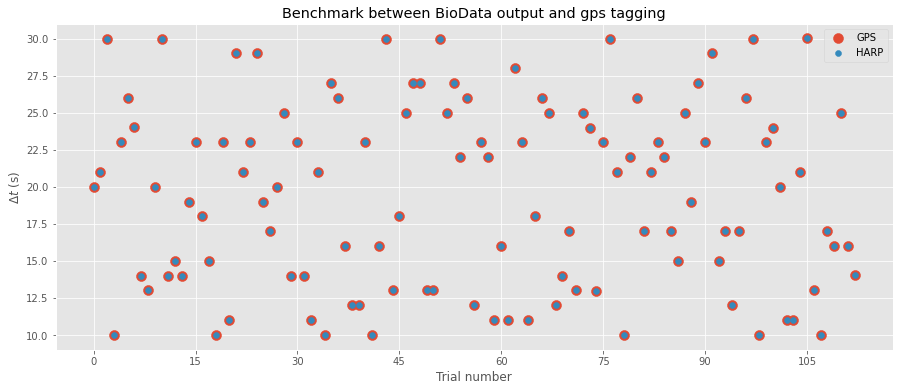

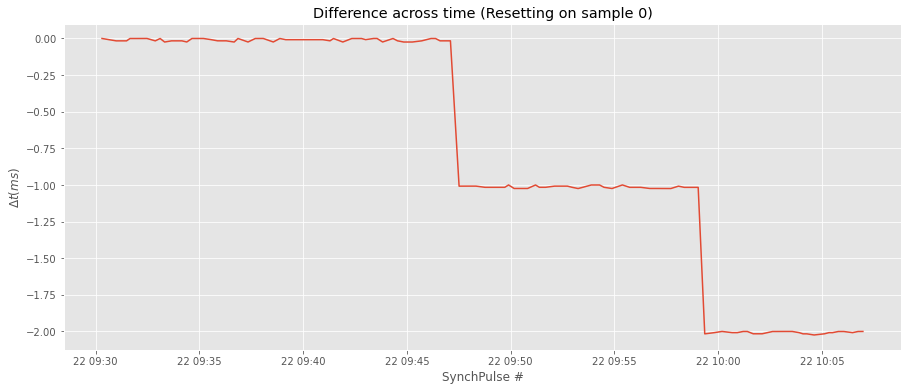

In [48]:
## Plot both
plt.figure(figsize=(15,6))
plt.title("Benchmark between BioData output and gps tagging")
plt.scatter(np.arange(len(risingEdgeEvents)-1), np.diff(risingEdgeEvents.values)*1e-3, 100,label = "GPS")
plt.scatter(np.arange(len(harp_sync_out)-1), np.diff(harp_sync_out.index)/np.timedelta64(1, 's'), label = "HARP")

ax = plt.gca()
from matplotlib.ticker import MaxNLocator
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.ylabel('$\Delta t$ (s)')
plt.xlabel('Trial number')
plt.legend()
plt.show()

## If we reset on the first value of the stream, we can check the accumulated drift:

harp_sync_ts = (harp_sync_out.index - harp_sync_out.index[0]) / np.timedelta64(1, 'ms')
gps_sync_ts = risingEdgeEvents.values
gps_sync_ts = gps_sync_ts - gps_sync_ts[0]

plt.figure(figsize=(15,6))
plt.plot(harp_sync_out.index, (harp_sync_ts - gps_sync_ts))
plt.xlabel("SynchPulse #")
plt.ylabel("$\Delta t (ms)$")
plt.title("Difference across time (Resetting on sample 0)")
plt.show()

In [101]:
# Use the PPS pulse
tim_tp = streams.UBX.filter_event("TIM-TP") #1sec heartbeat
tim_tp.insert(tim_tp.shape[1], "timestamp", tim_tp.apply(lambda x : x.loc["Message"].towMS, axis = 1), False)

harp_sync_in = streams.BioData.DigitalIn.data.iloc[
    np.where(np.diff((streams.BioData.DigitalIn.data["Value"].values & 2 > 0).astype(float)) == 1)[0] + 1
    ,:]#shift by one

#Since we dont know the phase, we should discard anything before the first sync pulse
first_harp = harp_sync_out.index[0]
harp_sync_in = harp_sync_in[harp_sync_in.index >= first_harp]

first_gps = tim_tm2.iloc[0].RisingEdge
tim_tp = tim_tp[tim_tp.timestamp >= first_gps]

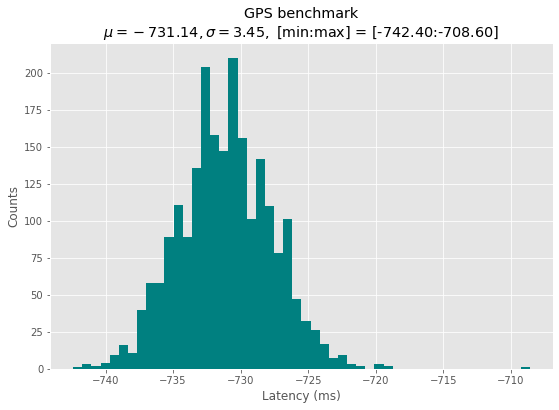

In [149]:
delta_t = tim_tp.index.values[:-1] - harp_sync_in.index.values
delta_t = delta_t / np.timedelta64(1, 'ms')
delta_t

plt.figure(figsize= (9,6))
plt.hist(delta_t, bins = 50, color= "Teal")
plt.xlabel('Latency (ms)')
plt.ylabel('Counts')
plt.title(f'GPS benchmark\n$\mu = {np.mean(delta_t):.2f}, \sigma = {np.std(delta_t):.2f},$ [min:max] = [{np.min(delta_t):.2f}:{np.max(delta_t):.2f}]')
plt.show()

In [141]:
a = np.diff(tim_tp.index.values )/ pd.Timedelta(milliseconds=1)
np.where(a > 6000)


(array([ 716,  718, 1173], dtype=int64),)

In [142]:
a = np.diff(harp_sync_in.index.values )/ pd.Timedelta(milliseconds=1)
np.where(a > 6000)



(array([ 716,  718, 1173], dtype=int64),)